In [68]:
import pandas as pd
gh_url="https://github.com/lovajujo/stm32/blob/main/logs/log200919_1.csv"
df=pd.read_csv(gh_url, header=None, names=range(13), on_bad_lines='skip')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,<!DOCTYPE html>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"<html lang=""en"" data-color-mode=""auto"" data-li...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,<head>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"<meta charset=""utf-8"">",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"<link rel=""dns-prefetch"" href=""https://githu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,</template>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,</div>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,"<div id=""js-global-screen-reader-notice"" c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007,</body>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
import datetime
df_pos=df[(df[0]=="$GPRMC")]
df_pos=df[ (df[2]=="A")]
log_date=pd.to_datetime(df_pos[9].mode()[0]).strftime("%Y-%m-%d")
print(str(log_date))
df_pos=df_pos[[1,3,4,5,6]]
df_pos=df_pos.reset_index(drop=True)
#pd.set_option('display.max_rows', None)
#display(df_pos)

KeyError: ignored

In [ ]:
import numpy as np
df_pos[1]=np.where(df_pos[1].str.len()!=9, np.nan, df_pos[1])
df_pos[3]=np.where(df_pos[3].str.len()!=10, np.nan, df_pos[3])
df_pos[4]=np.where(df_pos[4].str.len()!=1, np.nan, df_pos[4])
df_pos[5]=np.where(df_pos[5].str.len()!=11, np.nan, df_pos[5])
df_pos[6]=np.where(df_pos[6].str.len()!=1, np.nan, df_pos[6])
df_pos[3]=np.where(df_pos[4]=="S", "-"+df_pos[3], df_pos[3])
df_pos[5]=np.where(df_pos[6]=="W", "-"+df_pos[5], df_pos[5])
print(df_pos.shape)
df_pos.isna().sum()

(685, 5)


1     9
3    18
4     6
5    25
6    20
dtype: int64

In [ ]:
def decimal_point_pos(c_str):
  c_str=c_str.replace('.', '')
  return f"{c_str[:-7]}.{c_str[-7:]}"

def convert_dms(c_str):
  d=c_str[:-8]
  m=f"{c_str[-7:-5]}.{c_str[-5:]}"
  return round(float(d)+float(m)/60,7)

def convert_time(time):
  h=str(time)[0:2]
  m=str(time)[2:4]
  s=str(time)[4:]
  return((float(h)+2)*3600+float(m)*60+float(s))

df_pos[3]=df_pos[3].dropna().apply(decimal_point_pos)
df_pos[5]=df_pos[5].dropna().apply(decimal_point_pos)
df_pos['lat_dms']=df_pos[3].dropna().astype(float)
df_pos['long_dms']=df_pos[5].dropna().astype(float)
df_pos['lat_d']=df_pos[3].dropna().apply(convert_dms)
df_pos['long_d']=df_pos[5].dropna().apply(convert_dms)
df_pos['time_in_sec']=df_pos[1].dropna().apply(convert_time)

In [ ]:

coords=pd.DataFrame()
coords[['time_in_sec','lat_dms', 'long_dms','lat_d', 'long_d']]=df_pos[['time_in_sec','lat_dms', 'long_dms','lat_d', 'long_d']].astype(float)
coords['time']=pd.to_datetime(coords['time_in_sec'], unit='s').dt.strftime("%H:%M:%S")
coords.head()


,time_in_sec,lat_dms,long_dms,lat_d,long_d,time
0,62882.0,46.128042,20.065383,46.213403,20.108972,17:28:02
1,62883.0,46.128070,20.065395,46.213449,20.108991,17:28:03
2,62884.0,46.128099,20.065405,46.213498,20.109009,17:28:04
3,62885.0,46.128128,20.065415,46.213546,20.109025,17:28:05
4,62886.0,46.128157,20.065425,46.213594,20.109042,17:28:06


In [ ]:
coords=coords.interpolate()

In [ ]:
#distance

coords['dlat']=coords['lat_d'].diff()*np.pi/180
coords['dlong']=coords['long_d'].diff()*np.pi/180
coords['lat_rad']=coords['lat_d']*np.pi/180
coords['a']=pow(np.sin(coords['dlat']/2), 2)+pow(np.sin(coords['dlong']/2),2)*np.cos(coords['lat_rad'].shift(1)*np.cos(coords['lat_rad']))
coords['c']=2*np.arcsin(np.sqrt(coords['a']))
coords['distance']=6371000*coords['c']

coords.drop(columns=['a', 'c', 'dlat', 'dlong', 'lat_rad'], inplace=True)
coords.head(10)

,time_in_sec,lat_dms,long_dms,lat_d,long_d,time,distance
0,62882.0,46.128042,20.065383,46.213403,20.108972,17:28:02,NaN
1,62883.0,46.128070,20.065395,46.213449,20.108991,17:28:03,5.507393
2,62884.0,46.128099,20.065405,46.213498,20.109009,17:28:04,5.673334
3,62885.0,46.128128,20.065415,46.213546,20.109025,17:28:05,5.666645
4,62886.0,46.128157,20.065425,46.213594,20.109042,17:28:06,5.610958
5,62887.0,46.128185,20.065434,46.213642,20.109057,17:28:07,5.477302
6,62888.0,46.128213,20.065445,46.213689,20.109075,17:28:08,5.541739
7,62889.0,46.128241,20.065455,46.213735,20.109092,17:28:09,5.388751
8,62890.0,46.128270,20.065465,46.213783,20.109108,17:28:10,5.603297
9,62891.0,46.128300,20.065474,46.213834,20.109123,17:28:11,5.888915


In [ ]:

coords['speed_mps']=coords['distance']/coords['time_in_sec'].diff()
print(coords['speed_mps'].mean()*3.6)
coords.head(20)
#1 kt = 0.51444 m/s


18.80320984681108


,time_in_sec,lat_dms,long_dms,lat_d,long_d,time,distance,speed_mps
0,62882.0,46.128042,20.065383,46.213403,20.108972,17:28:02,NaN,NaN
1,62883.0,46.128070,20.065395,46.213449,20.108991,17:28:03,5.507393,5.507393
2,62884.0,46.128099,20.065405,46.213498,20.109009,17:28:04,5.673334,5.673334
3,62885.0,46.128128,20.065415,46.213546,20.109025,17:28:05,5.666645,5.666645
4,62886.0,46.128157,20.065425,46.213594,20.109042,17:28:06,5.610958,5.610958
5,62887.0,46.128185,20.065434,46.213642,20.109057,17:28:07,5.477302,5.477302
6,62888.0,46.128213,20.065445,46.213689,20.109075,17:28:08,5.541739,5.541739
7,62889.0,46.128241,20.065455,46.213735,20.109092,17:28:09,5.388751,5.388751
8,62890.0,46.128270,20.065465,46.213783,20.109108,17:28:10,5.603297,5.603297
9,62891.0,46.128300,20.065474,46.213834,20.109123,17:28:11,5.888915,5.888915


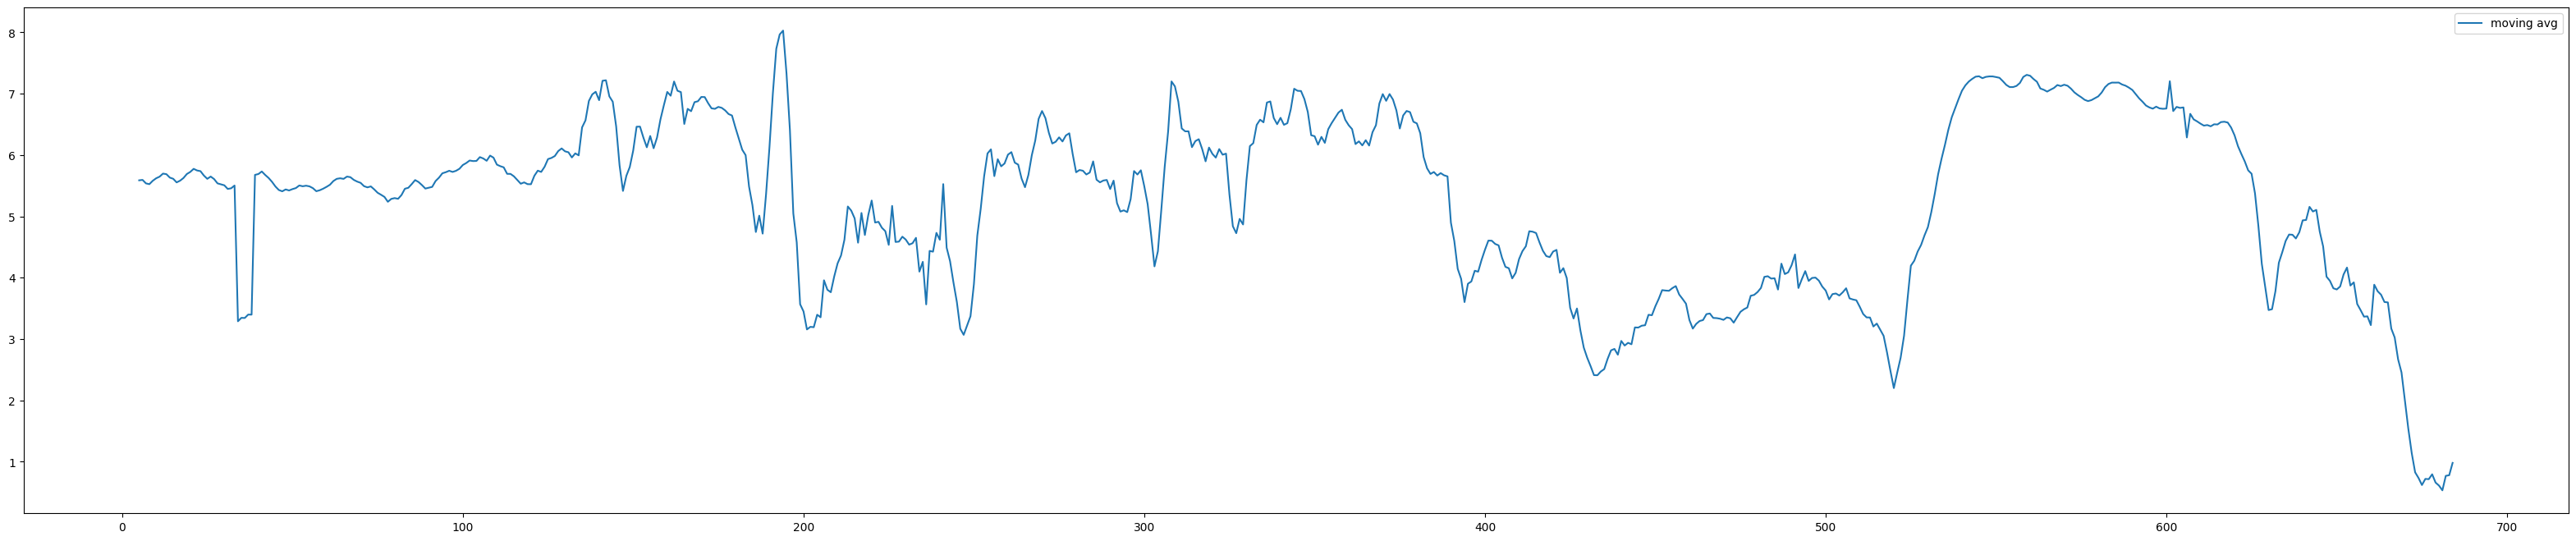

In [ ]:
import matplotlib.pyplot as plt
coords['speed_mps_moving']=coords['speed_mps'].rolling(5).mean()
plt.figure(figsize=(40,8))
plt.plot(coords['speed_mps_moving'], label='moving avg')
#plt.plot(coords['speed_mps'], label="mps")
plt.legend()
plt.show()

<Axes: xlabel='long_dms'>

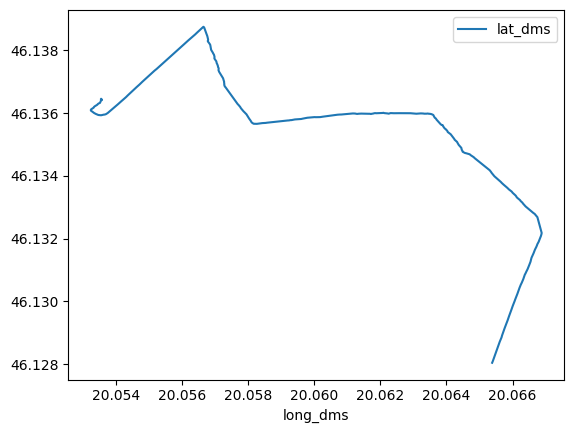

In [ ]:
coords.plot(x='long_dms', y='lat_dms')

In [ ]:
c=coords[['lat_d', 'long_d']]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
c.to_csv('/content/drive/MyDrive/coords.csv', index=False, encoding="utf-16")

MessageError: ignored

In [ ]:
!pip install folium

In [ ]:
import folium
map = folium.Map(location=[coords['lat_d'].mean(), coords['long_d'].mean()])
points=coords[['lat_d', 'long_d']].to_numpy()
#points

In [ ]:

for point in points:
  folium.CircleMarker(point,radius = 0.5,color = 'orange',fill = True).add_to(map)
map

In [ ]:
import plotly.express as px
fig = px.scatter_geo(coords, lat='lat_d', lon='long_d',
                  color='speed_mps',
                  hover_name=coords['time'],
                  hover_data='speed_mps',
                     fitbounds="locations")
fig.show()
#animation_frame='time',

In [ ]:
coords['time'].tail()

3051    19:19:55
3052    19:19:56
3053    19:19:57
3054    19:19:58
3055    19:20:04
Name: time, dtype: object

In [ ]:
print("activity started: ", log_date, pd.to_datetime(coords.iloc[0][5]).strftime("%H:%M:%S"))
duration=coords.loc[len(coords)-1][0]-coords.loc[0][0]
print("duration (h:m:s): ", datetime.timedelta(seconds=duration))
dist=coords['distance'].sum()
if dist<1000:
  print("distance: ", int(dist),"m")
else:
  print("distance: ", round(dist/1000,2),"km")
print("average speed :",round(dist/(coords.iloc[len(coords)-1][0]-coords.iloc[0][0])*3.6,2),"km/h")
print("max speed: ",round(coords['speed_mps_moving'].max()*3.6,1),"km/h")

activity started:  2023-09-19 17:28:02
duration (h:m:s):  0:13:42
distance:  4.22 km
average speed : 18.48 km/h
max speed:  28.9 km/h


In [69]:
!apt-get install -qq git

In [70]:
from getpass import getpass
import os
os.environ['GITHUB_USERNAME'] = getpass('GitHub username:')
os.environ['GITHUB_TOKEN'] = getpass('GitHub token:')

GitHub username:··········
GitHub token:··········


In [71]:
!git clone https://github.com/lovajujo/stm32.git

Cloning into 'stm32'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 276 (delta 89), reused 269 (delta 83), pack-reused 0
Receiving objects: 100% (276/276), 6.14 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [73]:
!git add gpslogs.ipynb
!git commit -m "ipynb commit"
!git push

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
